In [11]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
import os
import json
import re
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import string
from scipy.stats.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

import seaborn as sns
import random as rand

from bs4 import BeautifulSoup
import requests


In [2]:
def Insta(user):
    url = "https://instagram.com/"+user
    r = requests.get(url)
    data = r.text
    soup = BeautifulSoup(data, "lxml")

    for meta in soup.find_all('meta'):
        if meta.get('name') == 'description':
            content = meta.get('content')
            content = content.split(" ")
            return content

In [3]:
PATH="D:\\Instagram\\instagram-data\\"

In [4]:
print("Reading file is in progress")
Likes=[]
Comments=[]
NoofTags=[]
IsVideo=[]
Total_posts=[]
Followers=[]
Following=[]
Username=[]
for i in os.listdir(PATH):
    content=Insta(i)
    file=PATH+i+"\\"
    if(os.path.isdir(file)):
        #print(i)
        for j in os.listdir(file):
                types=os.path.splitext(file+j)[1]
                if(types==".json" and file+j==PATH+i+"\\"+i+".json"):
                    with open(file+j, encoding="utf8") as json_file:  
                        data = json.load(json_file)
                        for datas in data:
                            Likes.append(datas["edge_media_preview_like"].get("count"))
                            Comments.append(datas["edge_media_to_comment"].get("count"))
                            try:
                                if("tags" in datas):
                                    NoofTags.append(len(datas["tags"]))
                                else :
                                    NoofTags.append(0)
                            except json.JSONDecodeError:
                                print("Exception Error")
                            IsVideo.append(datas["is_video"])
                            Followers.append(content[0])
                            Following.append(content[2])
                            Total_posts.append(content[4])
                            Username.append(i)

survey=pd.read_csv("D:\\Instagram\\User_Category.csv")                             
survey.index=survey.User
print("Reading file is completed")

Reading file is in progress
Reading file is completed


In [5]:
#for i in MetricCategory['Total_posts'].unique() : print(int(i.replace(',','')))
User_Metric=pd.DataFrame({"UserName":Username,"Likes":Likes,"Comments":Comments,"NoofTags":NoofTags,"IsVideo":IsVideo,"Total_posts":Total_posts, "Followers":Followers,"Following":Following})
User_Metric['IsVideo']=User_Metric['IsVideo'].apply(lambda x: 1 if x==True else 0)
User_Metric['Total_posts']=User_Metric['Total_posts'].apply(lambda x: int(x.replace(',','')) )
User_Metric['Followers']=User_Metric['Followers'].apply(lambda x: int(x.replace(',','')) )
User_Metric['Following']=User_Metric['Following'].apply(lambda x: int(x.replace(',','')) )
User_Metric.index=User_Metric.UserName
MetricCategory=pd.merge(survey,User_Metric, left_on='User',right_index=True, how='inner')
MetricCategory=MetricCategory[['Category', 'Likes', 'Comments', 'NoofTags', 'IsVideo', 'Total_posts','Followers', 'Following']]
MetricCategory.index=MetricCategory.Category
Metrics=MetricCategory[[ 'Likes', 'Comments', 'NoofTags', 'IsVideo', 'Total_posts','Followers', 'Following']]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: FutureWarning: 'User' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


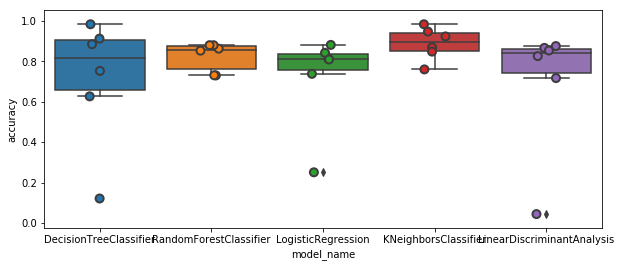

model_name
DecisionTreeClassifier        0.713515
KNeighborsClassifier          0.888315
LinearDiscriminantAnalysis    0.697117
LogisticRegression            0.722181
RandomForestClassifier        0.822600
Name: accuracy, dtype: float64

In [6]:
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(),
    LinearDiscriminantAnalysis()
]

CV = 6
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, Metrics, MetricCategory.Category, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

fig, ax = plt.subplots(figsize=(10,4))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()


In [ ]:
#Change the model as per Accuracy
model = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(Metrics, MetricCategory.Category,  test_size=0.40, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=MetricCategory.Category, yticklabels=MetricCategory.Category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
for col in ['Neuroticism','Extraversion','Openness','Agreeableness','Conscientiousness'] :
    MetricCategory[col]=MetricCategory.Category.apply(lambda e: col in e)

In [35]:
Categories=['Neuroticism', 'Extraversion','Openness', 'Agreeableness', 'Conscientiousness']
MetricCategoryMetric=MetricCategory[['Likes', 'Comments', 'NoofTags', 'IsVideo', 'Total_posts',
       'Followers', 'Following', 'Neuroticism', 'Extraversion', 'Openness',
       'Agreeableness', 'Conscientiousness']]
#MetricCategoryMetric.columns

Index(['Likes', 'Comments', 'NoofTags', 'IsVideo', 'Total_posts', 'Followers',
       'Following', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness',
       'Conscientiousness'],
      dtype='object')

In [24]:
Pearsoncorr=[]
Pearsonp=[]

for i in Metrics.columns :
    for j in Categories :
        Pearsoncorr.append(pearsonr(MetricCategoryMetric[i],MetricCategoryMetric[j])[0])
        Pearsonp.append(pearsonr(MetricCategoryMetric[i],MetricCategoryMetric[j])[1])

Pearsoncorr=np.asarray(Pearsoncorr).reshape(7,5)
Pearsonp=np.asarray(Pearsonp).reshape(7,5)

Pearsoncorr=pd.DataFrame(Pearsoncorr, columns=Categories)
Pearsoncorr.index=Metrics.columns

Pearsonp=pd.DataFrame(Pearsonp, columns=Categories)
Pearsonp.index=Metrics.columns


In [36]:
Pearsoncorr

,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness
Likes,-0.141760,-0.204159,-0.096600,-0.053347,0.294217
Comments,-0.088739,-0.147188,-0.067854,-0.057425,0.213143
NoofTags,-0.045943,-0.041653,-0.053520,-0.096192,0.118962
IsVideo,-0.031780,0.034983,0.030379,-0.030743,-0.009312
Total_posts,-0.152777,0.125779,-0.160568,-0.255558,0.148439
Followers,-0.135359,-0.097516,-0.092848,-0.142679,0.243931
Following,-0.021657,-0.282155,-0.085040,-0.183694,0.350236


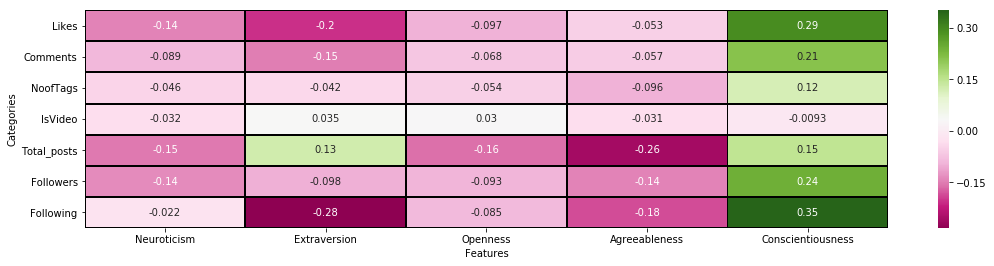

In [28]:
fig, ax = plt.subplots(figsize=(18,4))
sns.heatmap(Pearsoncorr, annot=True,cmap="PiYG", linewidths=1, linecolor='black')
plt.ylabel('Categories')
plt.xlabel('Features')
plt.show()

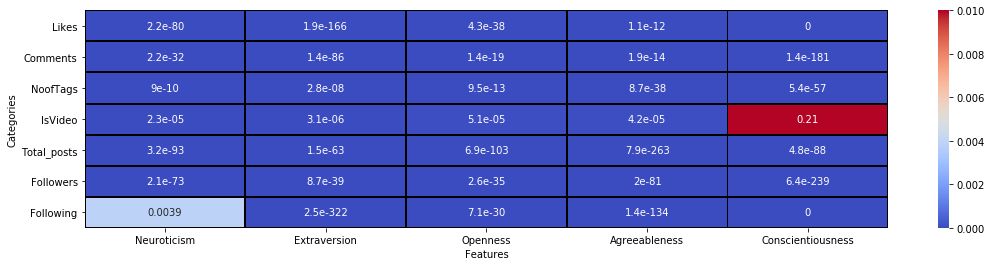

In [31]:
fig, ax = plt.subplots(figsize=(18,4))
sns.heatmap(Pearsonp, annot=True,cmap="coolwarm", linewidths=1, vmin=0, vmax=0.01, linecolor='black')
plt.ylabel('Categories')
plt.xlabel('Features')
plt.show()